# Import Modules

In [1]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
import math
import os
from keras.models import *
from keras.layers import * 
from keras.preprocessing import image
from keras import backend as K
from keras.applications import * 
from keras.applications.imagenet_utils import *
import pickle
import skimage.io
import skimage.transform
import skimage.filters

Using TensorFlow backend.


# Model

In [2]:
model = VGG16(weights='imagenet')
layer_dict={}
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
# Some Tools
def normalize(image):
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)
def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11, 11 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image =normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

選擇一張柯基照片
VGG16預測結果正確，是一隻柯基：

輸入圖片shape: (1, 224, 224, 3)
預測結果為: [[('n02113023', 'Pembroke', 0.69156653), ('n02113186', 'Cardigan', 0.30641055), ('n02110806', 'basenji', 0.00038243626), ('n02109961', 'Eskimo_dog', 0.00034497754), ('n02115641', 'dingo', 0.00024280699)]]


'\n預測結果為 Pembroke 柯基\n'

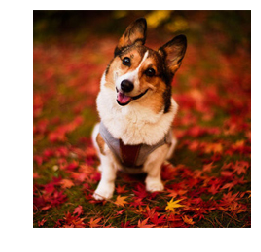

In [4]:
img_path = './dog.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.axis('off')
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('輸入圖片shape:', x.shape)

preds = model.predict(x)
print('預測結果為:', decode_predictions(preds))
label_index = np.argmax(preds)
"""
預測結果為 Pembroke 柯基
"""

為了想知道神經網路是如何辨識牠是一隻柯基的，
因此採用了隨機遮罩法，隨機將一些部位遮住，看看網路的反應。

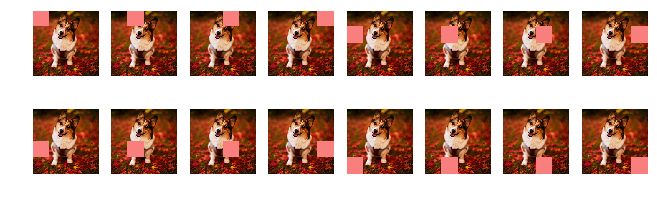

In [8]:
step = 56
heatmap_x = []
img = image.load_img(img_path, target_size=(224, 224))
x_arr = image.img_to_array(img)
for row in range(0, x_arr.shape[0], step):
    for col in range(0, x_arr.shape[1], step):
        new_image = x_arr.copy()#
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

display_images(heatmap_x, cols=8)

[('n02113023', 'Pembroke', 0.69535553), ('n02113186', 'Cardigan', 0.62176269), ('n02113023', 'Pembroke', 0.69322515), ('n02113023', 'Pembroke', 0.730003), ('n02113023', 'Pembroke', 0.7776916), ('n02113023', 'Pembroke', 0.79772681), ('n02113023', 'Pembroke', 0.79836607), ('n02113023', 'Pembroke', 0.77823544), ('n02113023', 'Pembroke', 0.77166355), ('n02113023', 'Pembroke', 0.87863022), ('n02113023', 'Pembroke', 0.84373897), ('n02113023', 'Pembroke', 0.77089065), ('n02113023', 'Pembroke', 0.72932845), ('n02113023', 'Pembroke', 0.81700671), ('n02113023', 'Pembroke', 0.75495493), ('n02113023', 'Pembroke', 0.72204399)]


'\n第一張遮罩圖預測結果變為Cardigan羊毛衫...\n這張圖遮住柯基的右眼\n'

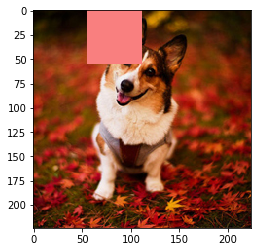

In [10]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
predodds=decode_predictions(heatmap_y)
predodds1=[y[0] for y in predodds]
print(predodds1)

plt.imshow(normalize(heatmap_x[1]))
"""
第一張遮罩圖預測結果變為Cardigan羊毛衫...
這張圖遮住柯基的右眼
"""

根據遮擋位置以及其機率下降，計算出來沒意義的區域，並進行遮罩：

[[ 0.36522064  1.          0.36946598  0.29617691]
 [ 0.20114544  0.16122028  0.1599464   0.20006172]
 [ 0.21315785  0.          0.06952953  0.21469803]
 [ 0.29752111  0.12280026  0.24645394  0.31203723]]


c:\users\user\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\user\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


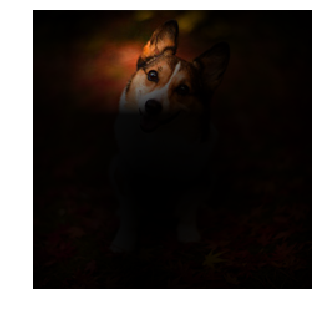

In [6]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
probs = heatmap_y[:, label_index]
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
print(heatmap)
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    display_images([image_heatmap], cols=2)
    
apply_mask(x_arr, heatmap**2)

可以發現網路主要是由柯基的右眼辨識出是柯基的，可以再視覺化每個神經元看到的柯基：

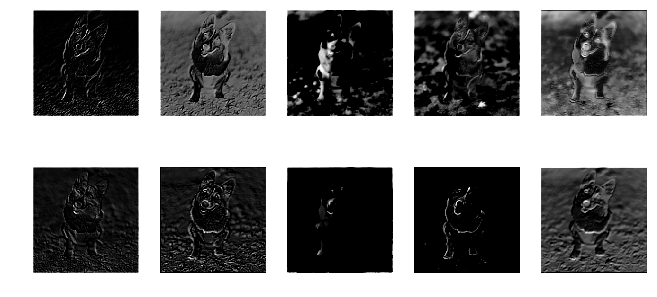

In [12]:
def read_layer(model, x, layer_name):
    """回傳指定神經層的活化值"""
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

    
x_process = np.expand_dims(x_arr, axis=0)
x_process = preprocess_input(x_process)
view_layer(model,x_process, "block1_conv2")

以上是還原block1_conv2後的視角，看起來是呈現線、邊的概念

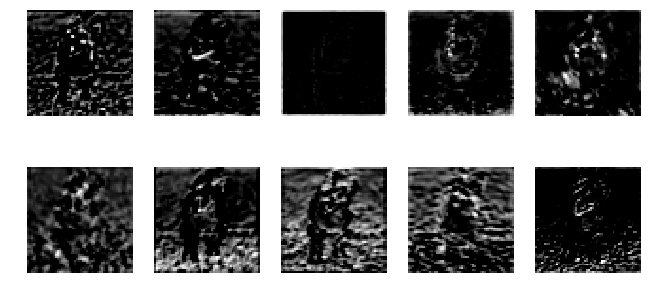

In [13]:
view_layer(model, x_process, "block3_conv1")

然後越往深層越抽象，到下面的block4_conv2看起來更不知所云

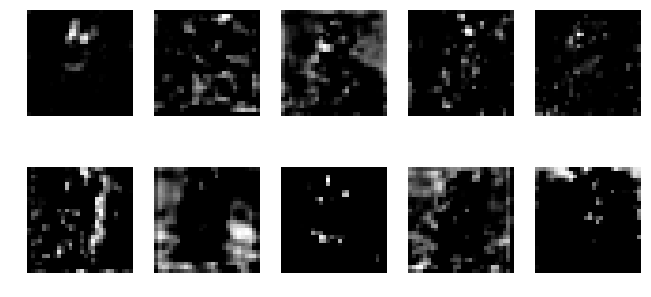

In [14]:
view_layer(model, x_process, "block4_conv2")

但其實與原圖疊合，可以發現這是柯基的眼睛，在這一層次已經看到了身體器官的特徵：

c:\users\user\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\user\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


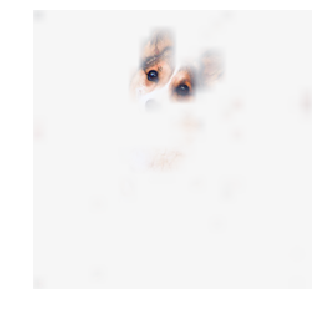

In [15]:
a = read_layer(model, x_process, "block4_conv2")
apply_mask(x_arr, a[:,:,0])